## Capstone Project Battle of the Neighbourhoods - Week4

#### Problem
A company is looking at setting up a pyrolysis plant to turn plastic into fuel, they want to set it up Cape Town and want to know which areas will be best suitable. They want neighbourhoods with Warehouses, Factories, Grocery stores, industrial parks, storage facilities and Liquor Stores, as they can place plastic recycle bins for collection at these locations. They also want to know where would be the best location to for the plant to run it effeciently and cost effective.


### Data description
I will be looking at the Cost of living for 3 Cities first, so there can be an idea of how different the costs are in cities located in devoloped countries vs a city in a developing country, this data I will obtain from from www.expatistan.com. I will use the foursquare API to map the locations of Recycling Places, Factories, Industrial Estates and Warehouses in Cape Town to see if there are any neighbourhoods that meet the criteria. The link to the project on github is https://github.com/pieterdt1979/coursera_capstone/tree/master/Capstone-Week4-5

In [1]:
## Importing all the modules that will be needed
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
mpl.style.use('ggplot')
from requests import get  # To scrape cost of living as well from:
from bs4 import BeautifulSoup   # https://www.expatistan.com/cost-of-living/toronto?currency=USD
                                # https://www.expatistan.com/cost-of-living/cape-town?currency=USD
                                # https://www.expatistan.com/cost-of-living/new-york
import folium
from sklearn.cluster import KMeans
import json
from datetime import datetime
import time
import csv
import sys

In [2]:
# Now we can get the cost of living for each country
tor_col = pd.read_html('https://www.expatistan.com/cost-of-living/toronto?currency=USD')
cpt_col = pd.read_html('https://www.expatistan.com/cost-of-living/cape-town?currency=USD')
ny_col = pd.read_html('https://www.expatistan.com/cost-of-living/new-york-city')

In [3]:
#Fix the data for the ny as we will be adding the columns for the two other cities to it
ny_col[0].drop('Food', axis=1, inplace=True)
ny_col[0].drop('Unnamed: 3', axis=1, inplace=True)
ny_col[0].rename(columns={'Food.1':'Expense Types', '[Edit]':'New York'}, inplace=True)
ny_col[0].drop([13,25,26,31,36,46], inplace=True)
ny_col[0].reset_index(drop=True, inplace=True)
ny_col[0].shape

(52, 2)

In [4]:
tor_col[0].drop([0,14,15,27,28,29,34,35,40,41,51,52], inplace=True)
tor_col[0].reset_index(drop=True, inplace=True)
tor_col[0].shape

(52, 4)

In [5]:
cpt_col[0].drop([0,14,15,27,28,29,34,35,40,41,51,52], inplace=True)
cpt_col[0].reset_index(drop=True, inplace=True)
cpt_col[0].shape

(52, 4)

In [6]:
ny_col[0]['Toronto'] = tor_col[0][tor_col[0].columns[3]]

In [7]:
ny_col[0]['Cape Town'] = cpt_col[0][cpt_col[0].columns[3]]

In [8]:
combined = pd.DataFrame(ny_col[0])
print('Data Types: ',combined.dtypes)
combined.head(5)

Data Types:  Expense Types    object
New York         object
Toronto          object
Cape Town        object
dtype: object


,Expense Types,New York,Toronto,Cape Town
0,Basic lunchtime menu (including a drink) in th...,$17,($13),($8)
1,Combo meal in fast food restaurant (Big Mac Me...,$9,($8),($4.19)
2,500 gr (1 lb.) of boneless chicken breast,$6,($5.67),($3.08)
3,1 liter (1 qt.) of whole fat milk,$1.20,($2.18),($0.87)
4,"12 eggs, large",$4.53,($2.90),($2.34)


In [9]:
# The data needs to be cleaned some moreso that the dollar values for each country is displayed as floats
# df[["bore", "stroke"]] = df[["bore", "stroke"]].astype("float")
combined[['New York', 'Toronto', 'Cape Town']]=combined[['New York', 'Toronto', 'Cape Town']].replace(to_replace=r'\$',
                                                                                                    value='', regex=True)
combined[['New York', 'Toronto', 'Cape Town']]=combined[['New York', 'Toronto', 'Cape Town']].replace(to_replace=r'\(',
                                                                                                    value='', regex=True)
combined[['New York', 'Toronto', 'Cape Town']]=combined[['New York', 'Toronto', 'Cape Town']].replace(to_replace=r'\)',
                                                                                                    value='', regex=True)
combined[['New York', 'Toronto', 'Cape Town']]=combined[['New York', 'Toronto', 'Cape Town']].replace(to_replace=r'\,',
                                                                                                    value='', regex=True)

In [10]:
combined[['New York', 'Toronto', 'Cape Town']] = combined[['New York', 'Toronto', 'Cape Town']].astype("float")
print(combined.dtypes) # Peeking the data types again
combined.head(5) # Just checking that nothing was lost in the conversion

Expense Types     object
New York         float64
Toronto          float64
Cape Town        float64
dtype: object


,Expense Types,New York,Toronto,Cape Town
0,Basic lunchtime menu (including a drink) in th...,17.00,13.00,8.00
1,Combo meal in fast food restaurant (Big Mac Me...,9.00,8.00,4.19
2,500 gr (1 lb.) of boneless chicken breast,6.00,5.67,3.08
3,1 liter (1 qt.) of whole fat milk,1.20,2.18,0.87
4,"12 eggs, large",4.53,2.90,2.34


In [11]:
combined.set_index('Expense Types', inplace=True) # Change the index

In [12]:
combined[32:41]

,New York,Toronto,Cape Town
Expense Types,,,
"Cold medicine for 6 days (Tylenol, Frenadol, Coldrex, or equivalent brands)",10.00,9.00,4.46
1 box of antibiotics (12 doses),28.00,21.00,10.00
Short visit to private Doctor (15 minutes),147.00,74.00,29.00
"1 box of 32 tampons (Tampax, OB, ...)",8.00,5.72,2.83
"Deodorant, roll-on (50ml ~ 1.5 oz.)",4.53,3.68,2.16
Hair shampoo 2-in-1 (400 ml ~ 12 oz.),6.00,3.75,3.28
4 rolls of toilet paper,4.35,2.11,1.56
Tube of toothpaste,1.93,1.90,1.28
Standard men's haircut in expat area of the city,28.00,20.00,9.00


In [13]:
# Splitting it for the different categories
food_comp = combined[0:13]
housing_comp = combined[13:24]
clothing_comp = combined[24:28]
transport_comp = combined[28:32]
care_comp = combined[32:41]
entertain_comp = combined[41:]

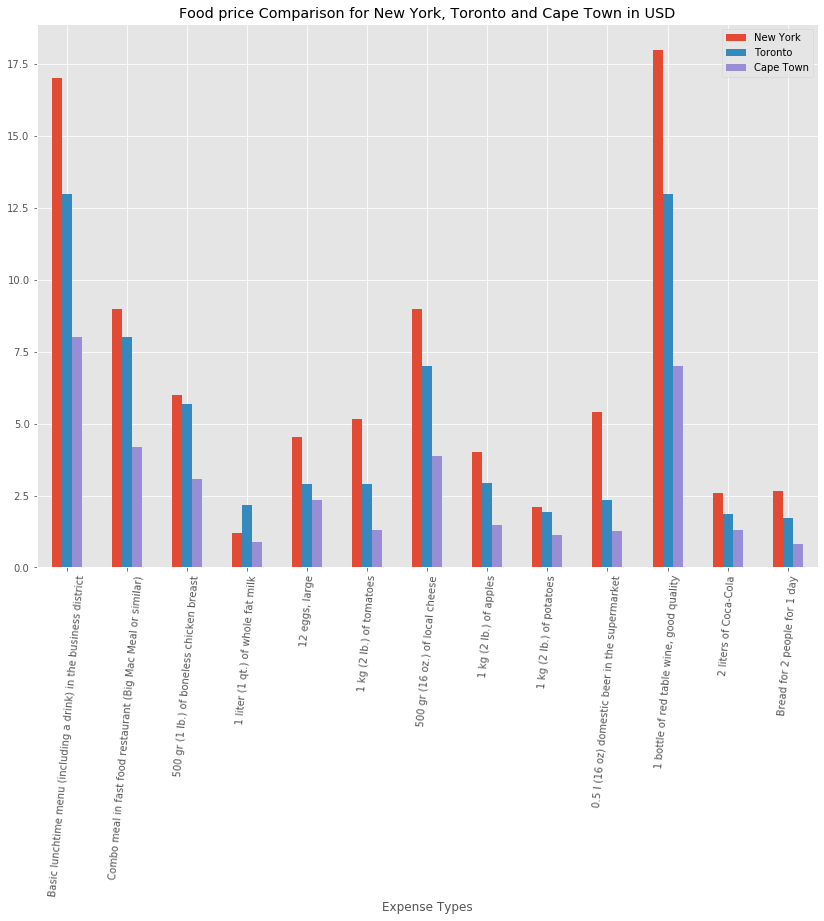

In [14]:
food_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Food price Comparison for New York, Toronto and Cape Town in USD')
plt.savefig('food_comp.jpg')

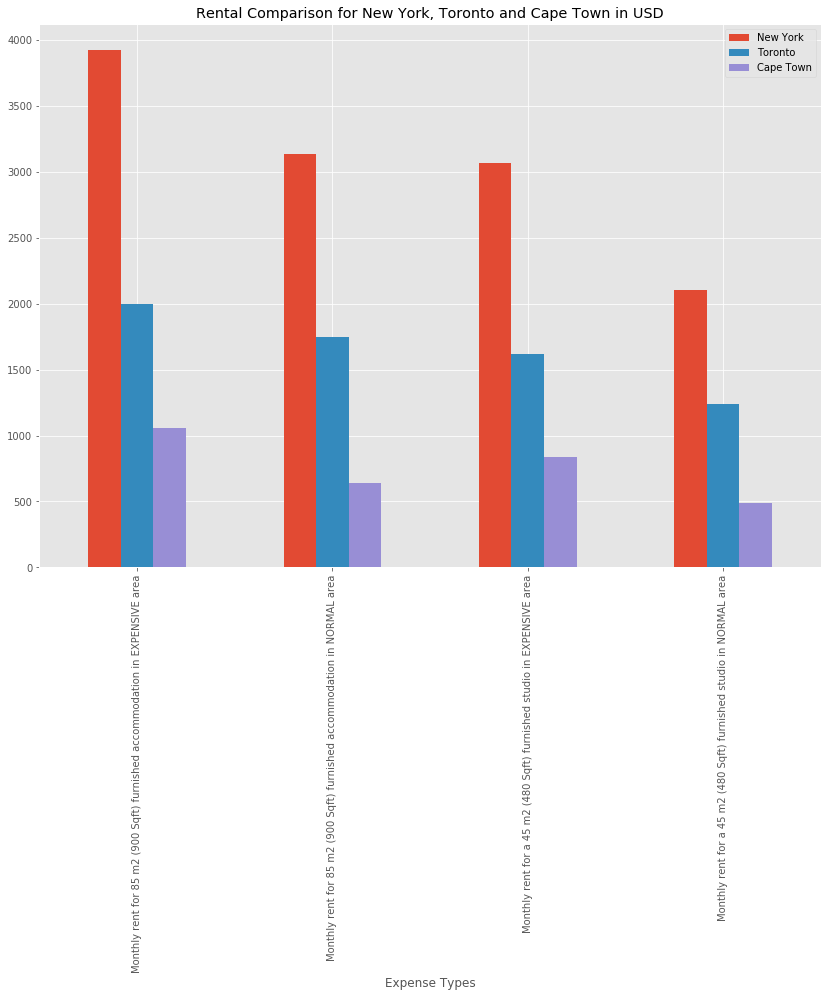

In [15]:
pd.DataFrame(housing_comp[0:2].append(housing_comp[3:5])).plot(kind='bar', figsize=(14,10))
plt.title('Rental Comparison for New York, Toronto and Cape Town in USD')
plt.savefig('rental_comp.jpg')

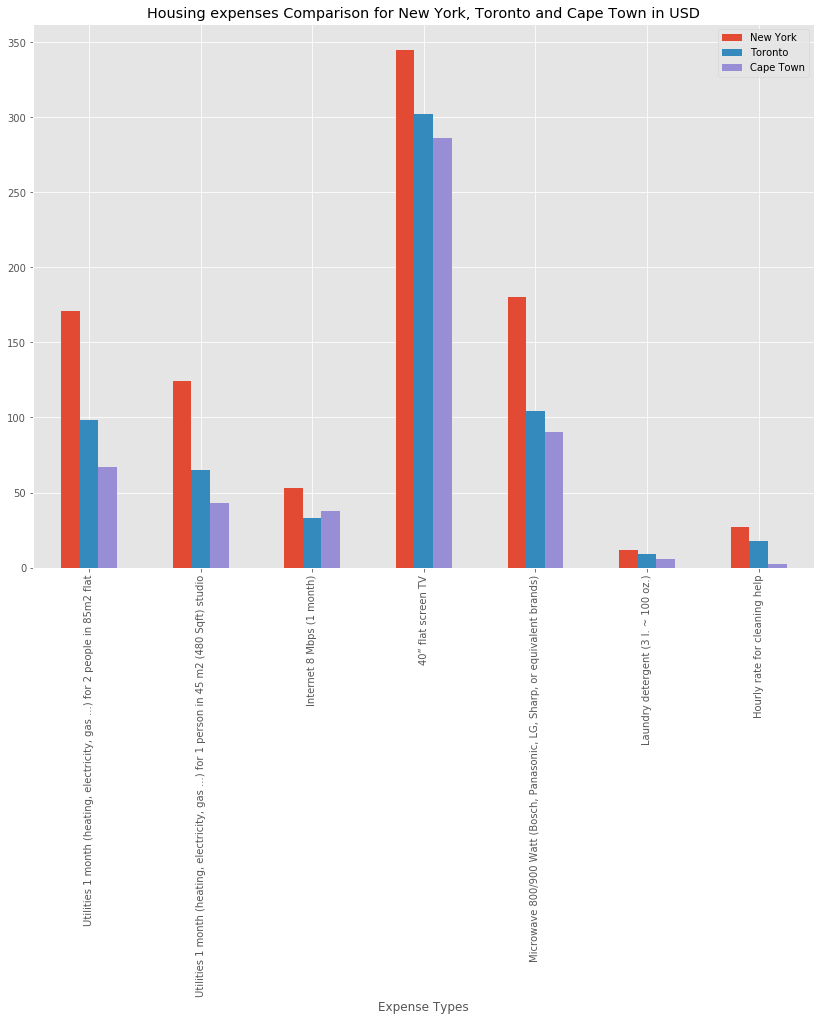

In [16]:
pd.DataFrame(housing_comp[2:3].append(housing_comp[5:])).plot(kind='bar', figsize=(14,10))
plt.title('Housing expenses Comparison for New York, Toronto and Cape Town in USD')
plt.savefig('house_hold.jpg')

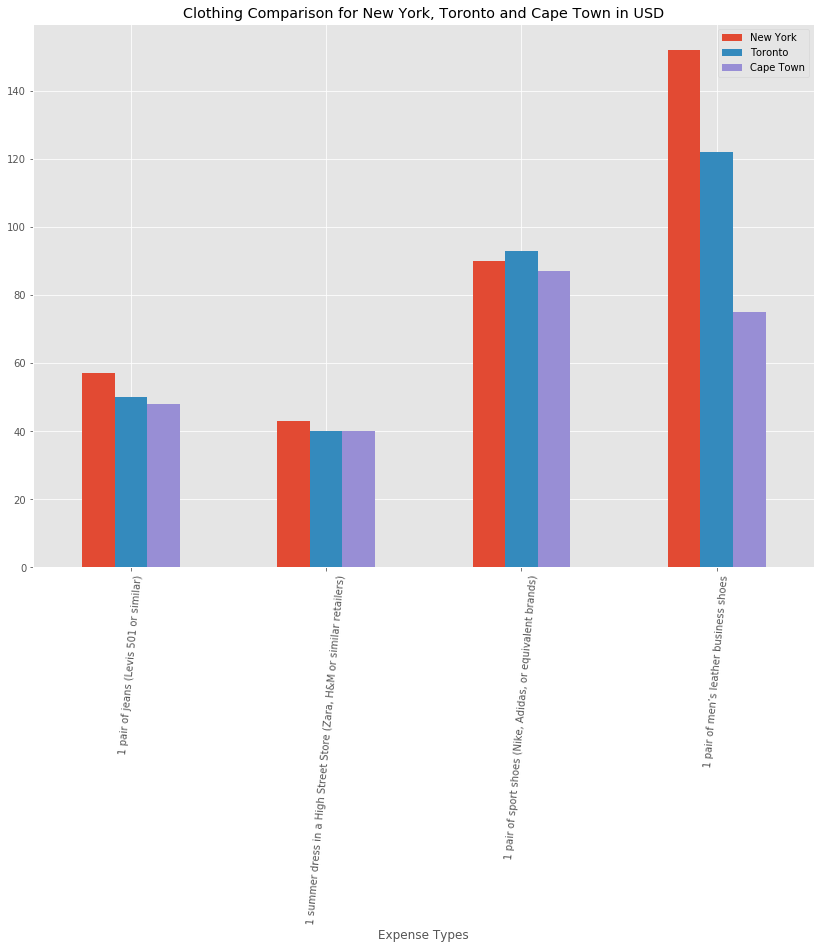

In [17]:
clothing_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Clothing Comparison for New York, Toronto and Cape Town in USD')
plt.savefig('clothing_comp.jpg')

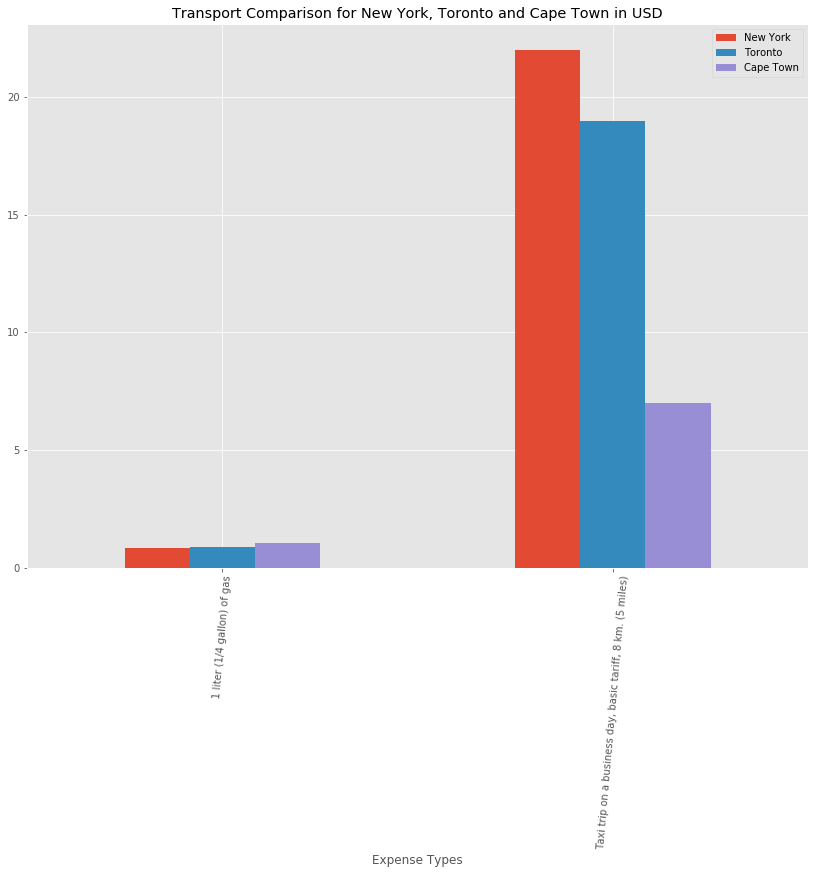

In [18]:
transport_comp[1::2].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Transport Comparison for New York, Toronto and Cape Town in USD')
plt.savefig('transport_comp_1.jpg') # Interesting Fuel in South-Africa is more expensive, but the taxi trip are cheaper

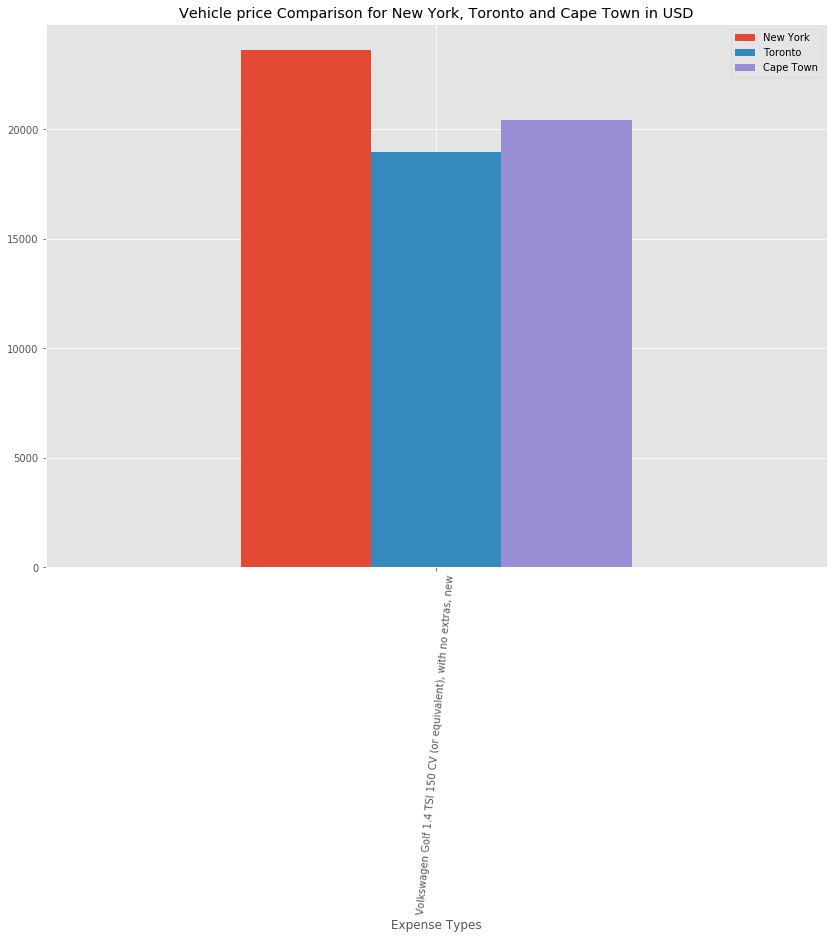

In [19]:
transport_comp[0:1].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Vehicle price Comparison for New York, Toronto and Cape Town in USD')
plt.savefig('transport_comp_2.jpg') 

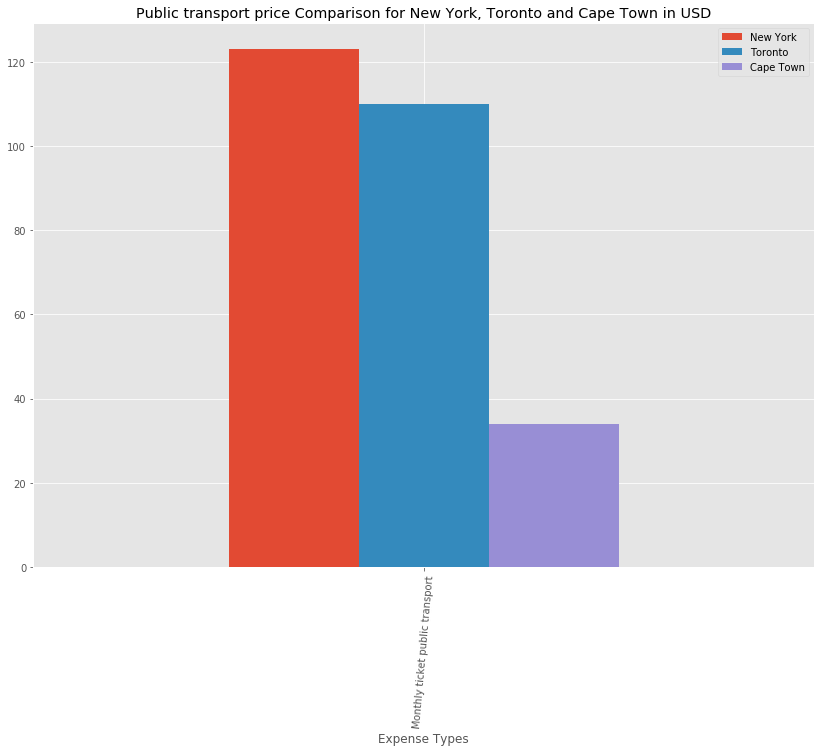

In [20]:
transport_comp[2:3].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Public transport price Comparison for New York, Toronto and Cape Town in USD')
plt.savefig('transport_comp_3.jpg') # Still wondering about the fuel that is more expensive, yet public transport is also cheaper

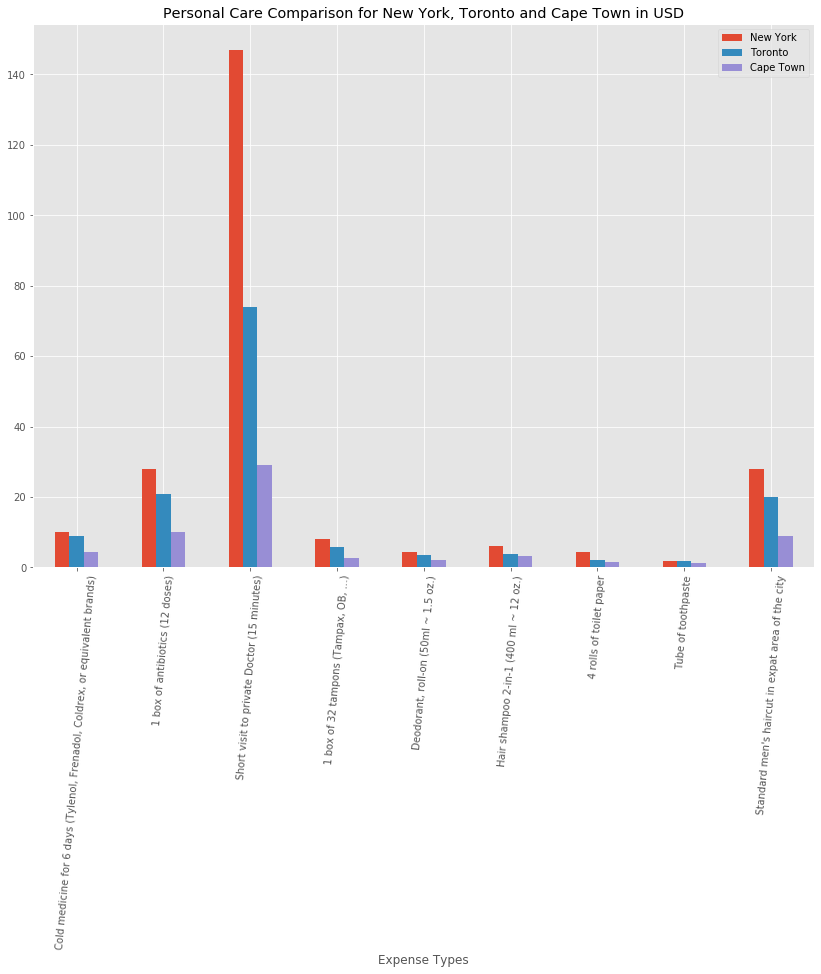

In [21]:
care_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Personal Care Comparison for New York, Toronto and Cape Town in USD')
plt.savefig('personal_care_comp.jpg') 

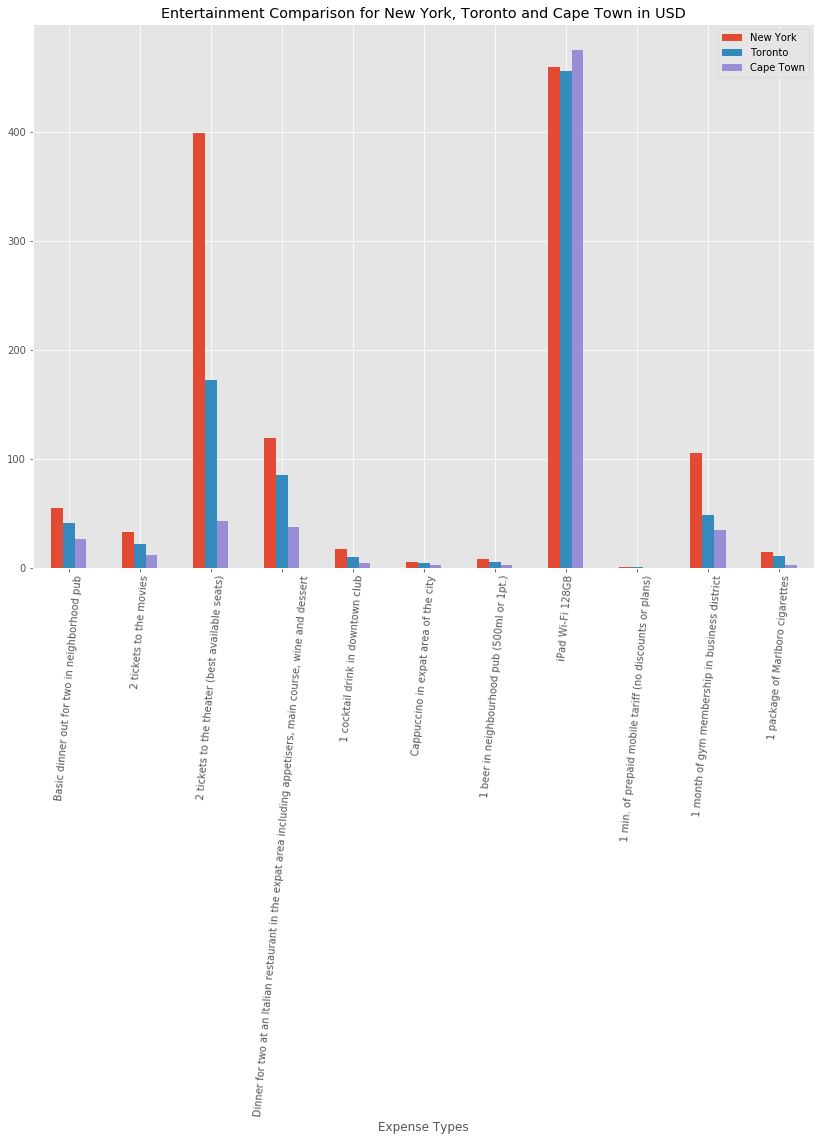

In [22]:
entertain_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Entertainment Comparison for New York, Toronto and Cape Town in USD')
plt.savefig('entertainment.jpg')

### Starting to explore Cape Town and the neighbourhoods

In [23]:
#Function to get the nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryids=[]):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        if len(categoryids) > 0:
            url = url + '&categoryId={}'.format(','.join(categoryids))
            
        # make the GET request
        results = get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        try:    
            venues_list.append([(
                name,
                lat,
                lng,
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass
    try:
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighbourhood', 'Latitude', 'Longitude',  
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
    except:
        nearby_venues = pd.DataFrame(columns=['Neighbourhood', 'Latitude', 'Longitude'
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])

    
    return(nearby_venues)

In [24]:
{
    "tags": [
        "hide_input",
    ]
}
CLIENT_ID = 'XSVHAZY2UJRGVE0WGHRIFL4VUWO3E1JSE0COGEKWOXMVMM3W' # your Foursquare ID
CLIENT_SECRET = '0GRW4DGJMGBQYAI3J4MG3ITDNLICPSR2BTYBRVSZ1CKNL2E2' # your Foursquare Secret
VERSION = '20191010' # Foursquare API version
LIMIT = 200 # Return a maximum of 200 venues per neighbourhood

In [25]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values (OpenStreetMaps)

def get_geo(address):
    address = address
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return address, latitude, longitude


In [26]:
#So let us start exploring the different Neighbourhoods in Cape Town
# The below data has already been formatted in a different notebook called 'Cape_Town_Data' also available on gitub
cpt_neighbourhoods = pd.read_csv('cape_town_data.csv')
# We will only be using 'Borough', 'Neighbourhood', 'Latitude', 'Longitude' from the loaded data so other columns can be dropped
cpt_neighbourhoods.drop(cpt_neighbourhoods.columns[[0,1,6,7,8,9,10,11,12,13,14,15,16]], axis=1, inplace=True)
print('Cape Town has {} boroughs and {} neighbourhoods.'.format(
        len(cpt_neighbourhoods['Borough'].unique()),
        cpt_neighbourhoods.shape[0]
    )
)
cpt_neighbourhoods.head()

Cape Town has 8 boroughs and 41 neighbourhoods.


,Borough,Neighbourhood,Latitude,Longitude
0,Cape Flats,Delft,-33.965556,18.644444
1,Cape Flats,Macassar,-34.066116,18.767495
2,Helderberg,"Firgrove, Somerset West",-34.040539,18.455753
3,Helderberg,"Gordon's Bay, Strand",-34.161125,18.868687
4,Northern Suburbs,"Brooklyn, Kensington, Maitland, Rugby",-33.908889,18.479167


In [27]:
# Categories = Warehouses, Factories, Shop & Service (only specific categories selecter here), 
# industrial parks, storage facilities, recycling
categories = ['4d954b0ea243a5684a65b473', '52e81612bcbc57f1066b7a36',
              '4eb1bea83b7b6f98df247e06', '56aa371be4b08b9a8d5734d7',
              '4f04b1572fb6e1c99f3db0bf', '4f4531084b9074f6e4fb0101', 
              '4bf58dd8d48988d1f6941735', '4bf58dd8d48988d118951735', 
              '4bf58dd8d48988d186941735', '52f2ab2ebcbc57f1066b8b46', 
              '50be8ee891d4fa8dcc7199a7', '4bf58dd8d48988d1fd941735', 
              '5744ccdfe4b0c0459246b4dc', '52e816a6bcbc57f1066b7a54']
cpt_venues = getNearbyVenues(list(cpt_neighbourhoods['Neighbourhood']), 
                             list(cpt_neighbourhoods['Latitude']),
                             list(cpt_neighbourhoods['Longitude']),
                                  radius=4000,
                                  categoryids=categories)
cpt_venues.head()  # Had to increase the search radius, as the Cape Flats borough didn't seem to return enough data from 4square

Delft
Macassar
Firgrove, Somerset West
Gordon's Bay, Strand
Brooklyn, Kensington, Maitland, Rugby
Ndabeni, Pinelands
Bothasig, Edgemead
Bloubergstrand, Melkbosstrand, Milnerton, Montague Gardens, Parklands, Table View, West Beach
Langa
Epping
Goodwood, Monte Vista, Thornton
Belhar
Panorama, Parow, Plattekloof
Bellville, Loevenstein
Durbanville
Brackenfell
Kraaifontein
Kuils River
Milnerton
Mowbray, Newlands, Rondebosch, Rosebank
Bishopscourt, Claremont, Harfield Village, Kenilworth
Gugulethu, Nyanga, Philippi
Athlone, Bonteheuwel
Crawford
Kenwyn, Lansdowne, Rondebosch East
Khayelitsha
Mitchells Plain, Samora Machel
Strandfontein
Ottery
Plumstead, Wynberg
Hout Bay, Imizamo Yethu, Llandudno
Constantia, Kreupelbosch, Meadowridge
SouthField
Salt River, Walmer Estate (District Six), Woodstock (including Upper Woodstock), Zonnebloem (District Six)
Observatory
Grassy Park, Lotus River
Lavender Hill
Lakeside, Marina da Gama, Muizenberg, St James
Bergvliet, Diep River, Heathfield, Kirstenhof, R

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Delft,-33.965556,18.644444,FreshStop at Caltex Voorbrugh,-33.974548,18.642966,Convenience Store
1,Delft,-33.965556,18.644444,FreshStop at Caltex Delft,-33.955997,18.647024,Convenience Store
2,Delft,-33.965556,18.644444,Engen Bellstar Service Station,-33.951365,18.647774,Convenience Store
3,Delft,-33.965556,18.644444,SPAR,-33.942385,18.626650,Convenience Store
4,Delft,-33.965556,18.644444,Engen Hindle Road Service Station,-33.979934,18.657914,Convenience Store


In [28]:
print('There are {} unique categories.'.format(len(cpt_venues['Venue Category'].unique())))
print('A total of {} venues has been returned'.format(cpt_venues.shape[0]))

There are 18 unique categories.
A total of 1527 venues has been returned


In [29]:
# one hot encoding
cpt_onehot = pd.get_dummies(cpt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cpt_onehot['Neighbourhood'] = cpt_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [cpt_onehot.columns[-1]] + list(cpt_onehot.columns[:-1])
cpt_onehot = cpt_onehot[fixed_columns]

print('The following venues types was returned: \n{}'.format('\n'.join(cpt_onehot.columns[1:])))

The following venues types was returned: 
Convenience Store
Department Store
Discount Store
Factory
Flea Market
Fruit & Vegetable Store
Gas Station
Grocery Store
Hardware Store
Liquor Store
Market
Miscellaneous Shop
Recycling Facility
Shopping Mall
Storage Facility
Supermarket
Warehouse
Warehouse Store


In [30]:
#Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
cpt_grouped = cpt_onehot.groupby('Neighbourhood').mean().reset_index()
cpt_grouped

,Neighbourhood,Convenience Store,Department Store,Discount Store,Factory,Flea Market,Fruit & Vegetable Store,Gas Station,Grocery Store,Hardware Store,Liquor Store,Market,Miscellaneous Shop,Recycling Facility,Shopping Mall,Storage Facility,Supermarket,Warehouse,Warehouse Store
0,"Athlone, Bonteheuwel",0.328125,0.046875,0.000000,0.000000,0.000000,0.000000,0.000000,0.171875,0.015625,0.062500,0.000000,0.000000,0.000000,0.281250,0.000000,0.093750,0.000000,0.000000
1,"Bakoven, Bantry Bay, Camps Bay, Clifton, Fresn...",0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000
2,Belhar,0.500000,0.000000,0.000000,0.250000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.062500,0.000000,0.000000
3,"Bellville, Loevenstein",0.287879,0.075758,0.000000,0.045455,0.000000,0.000000,0.106061,0.212121,0.000000,0.015152,0.000000,0.000000,0.000000,0.181818,0.030303,0.045455,0.000000,0.000000
4,"Bergvliet, Diep River, Heathfield, Kirstenhof,...",0.448980,0.061224,0.000000,0.000000,0.000000,0.000000,0.000000,0.244898,0.000000,0.000000,0.040816,0.020408,0.000000,0.163265,0.020408,0.000000,0.000000,0.000000
5,"Bishopscourt, Claremont, Harfield Village, Ken...",0.327869,0.081967,0.000000,0.000000,0.000000,0.000000,0.000000,0.147541,0.000000,0.049180,0.016393,0.000000,0.016393,0.262295,0.016393,0.081967,0.000000,0.000000
6,"Bloubergstrand, Melkbosstrand, Milnerton, Mont...",0.250000,0.214286,0.000000,0.000000,0.000000,0.000000,0.000000,0.214286,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.035714,0.000000,0.000000
7,"Bothasig, Edgemead",0.355932,0.050847,0.000000,0.067797,0.000000,0.016949,0.016949,0.084746,0.000000,0.000000,0.016949,0.000000,0.000000,0.237288,0.033898,0.101695,0.000000,0.016949
8,Brackenfell,0.420000,0.100000,0.000000,0.000000,0.000000,0.000000,0.040000,0.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.180000,0.000000,0.100000,0.000000,0.020000
9,"Brooklyn, Kensington, Maitland, Rugby",0.387755,0.040816,0.020408,0.061224,0.020408,0.000000,0.020408,0.204082,0.000000,0.000000,0.040816,0.000000,0.000000,0.142857,0.020408,0.040816,0.000000,0.000000


In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
# I will only look for the top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cpt_venues_sorted = pd.DataFrame(columns=columns)
cpt_venues_sorted['Neighbourhood'] = cpt_grouped['Neighbourhood']

for ind in np.arange(cpt_grouped.shape[0]):
    cpt_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cpt_grouped.iloc[ind, :], num_top_venues)

cpt_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Athlone, Bonteheuwel",Convenience Store,Shopping Mall,Grocery Store,Supermarket,Liquor Store,Department Store,Hardware Store,Market,Miscellaneous Shop,Warehouse
1,"Bakoven, Bantry Bay, Camps Bay, Clifton, Fresn...",Convenience Store,Grocery Store,Shopping Mall,Department Store,Discount Store,Factory,Flea Market,Fruit & Vegetable Store,Gas Station,Warehouse Store
2,Belhar,Convenience Store,Factory,Gas Station,Supermarket,Shopping Mall,Grocery Store,Department Store,Discount Store,Flea Market,Fruit & Vegetable Store
3,"Bellville, Loevenstein",Convenience Store,Grocery Store,Shopping Mall,Gas Station,Department Store,Supermarket,Factory,Storage Facility,Liquor Store,Fruit & Vegetable Store
4,"Bergvliet, Diep River, Heathfield, Kirstenhof,...",Convenience Store,Grocery Store,Shopping Mall,Department Store,Market,Storage Facility,Miscellaneous Shop,Fruit & Vegetable Store,Discount Store,Factory
5,"Bishopscourt, Claremont, Harfield Village, Ken...",Convenience Store,Shopping Mall,Grocery Store,Supermarket,Department Store,Liquor Store,Storage Facility,Recycling Facility,Market,Flea Market
6,"Bloubergstrand, Melkbosstrand, Milnerton, Mont...",Shopping Mall,Convenience Store,Grocery Store,Department Store,Supermarket,Discount Store,Factory,Flea Market,Fruit & Vegetable Store,Gas Station
7,"Bothasig, Edgemead",Convenience Store,Shopping Mall,Supermarket,Grocery Store,Factory,Department Store,Storage Facility,Fruit & Vegetable Store,Gas Station,Warehouse Store
8,Brackenfell,Convenience Store,Shopping Mall,Grocery Store,Supermarket,Department Store,Gas Station,Warehouse Store,Market,Liquor Store,Warehouse
9,"Brooklyn, Kensington, Maitland, Rugby",Convenience Store,Grocery Store,Shopping Mall,Factory,Supermarket,Department Store,Market,Storage Facility,Discount Store,Flea Market


In [34]:
# set number of clusters 
kclusters = 5

cpt_grouped_clustering = cpt_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cpt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 0, 1, 4, 0, 4, 4, 4, 1, 0, 0, 0, 4, 3, 4, 4, 0, 1, 4, 1, 3, 4,
       1, 3, 1, 4, 4, 0, 4, 2, 1, 1, 4, 0, 4, 1, 1, 1, 4, 0, 0],
      dtype=int32)

In [35]:
# add clustering labels
cpt_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cpt_merged = cpt_neighbourhoods

# merge the data to add latitude/longitude for each neighborhood
cpt_merged = cpt_merged.join(cpt_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

cpt_merged # check the columns

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cape Flats,Delft,-33.965556,18.644444,3,Convenience Store,Gas Station,Warehouse,Department Store,Discount Store,Factory,Flea Market,Fruit & Vegetable Store,Grocery Store,Warehouse Store
1,Cape Flats,Macassar,-34.066116,18.767495,2,Gas Station,Shopping Mall,Warehouse Store,Grocery Store,Department Store,Discount Store,Factory,Flea Market,Fruit & Vegetable Store,Hardware Store
2,Helderberg,"Firgrove, Somerset West",-34.040539,18.455753,0,Convenience Store,Grocery Store,Shopping Mall,Department Store,Market,Storage Facility,Miscellaneous Shop,Liquor Store,Gas Station,Flea Market
3,Helderberg,"Gordon's Bay, Strand",-34.161125,18.868687,4,Shopping Mall,Convenience Store,Grocery Store,Supermarket,Department Store,Discount Store,Factory,Flea Market,Fruit & Vegetable Store,Gas Station
4,Northern Suburbs,"Brooklyn, Kensington, Maitland, Rugby",-33.908889,18.479167,0,Convenience Store,Grocery Store,Shopping Mall,Factory,Supermarket,Department Store,Market,Storage Facility,Discount Store,Flea Market
5,Southern Suburbs,"Ndabeni, Pinelands",-33.928485,18.491624,0,Convenience Store,Grocery Store,Shopping Mall,Factory,Supermarket,Market,Flea Market,Storage Facility,Department Store,Liquor Store
6,Northern Suburbs,"Bothasig, Edgemead",-33.859444,18.541111,4,Convenience Store,Shopping Mall,Supermarket,Grocery Store,Factory,Department Store,Storage Facility,Fruit & Vegetable Store,Gas Station,Warehouse Store
7,West Coast,"Bloubergstrand, Melkbosstrand, Milnerton, Mont...",-33.797336,18.461023,4,Shopping Mall,Convenience Store,Grocery Store,Department Store,Supermarket,Discount Store,Factory,Flea Market,Fruit & Vegetable Store,Gas Station
8,Cape Flats,Langa,-33.945556,18.530000,0,Convenience Store,Shopping Mall,Grocery Store,Liquor Store,Warehouse Store,Supermarket,Recycling Facility,Miscellaneous Shop,Market,Storage Facility
9,Cape Flats,Epping,-33.933369,18.534577,4,Convenience Store,Grocery Store,Shopping Mall,Liquor Store,Warehouse Store,Supermarket,Recycling Facility,Miscellaneous Shop,Market,Storage Facility


In [36]:
# From the below we can see that there are about 13 neighbourhoods in cluster 4
cpt_merged['Cluster Labels'].value_counts()

4    16
1    11
0    10
3     3
2     1
Name: Cluster Labels, dtype: int64

In [37]:
# create map of all the different clusters
address, latitude, longitude = get_geo('Cape Town, ZA')
cpt_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cpt_merged['Latitude'], cpt_merged['Longitude'], cpt_merged['Neighbourhood'], 
                                  cpt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cpt_clusters)

cpt_clusters.save('cpt_clusters.html')
cpt_clusters

If we have a look at the clusters on the map, we see that cluster 4 is the neighbourhoods that are mostly the same

In [38]:
#Let's have a look at cluster 4
top_clusters = cpt_merged.loc[cpt_merged['Cluster Labels'] == 4]
top_clusters.reset_index(inplace=True, drop=True)

In [39]:
# Now we can get all the venues for these areas and plot them on the map
g_top_venues = cpt_venues[cpt_venues['Neighbourhood'].isin(list(top_clusters['Neighbourhood']))]
g_top_venues

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
59,"Gordon's Bay, Strand",-34.161125,18.868687,Woolworths Food,-34.155252,18.872750,Convenience Store
60,"Gordon's Bay, Strand",-34.161125,18.868687,SPAR,-34.154772,18.868860,Grocery Store
61,"Gordon's Bay, Strand",-34.161125,18.868687,Mountain View Centre,-34.155050,18.872396,Shopping Mall
62,"Gordon's Bay, Strand",-34.161125,18.868687,Gordon's Bay Mall,-34.150710,18.881516,Shopping Mall
63,"Gordon's Bay, Strand",-34.161125,18.868687,Pick n Pay Family Gordons Bay,-34.147042,18.857283,Convenience Store
64,"Gordon's Bay, Strand",-34.161125,18.868687,Pick n Pay,-34.146767,18.856849,Supermarket
65,"Gordon's Bay, Strand",-34.161125,18.868687,Village Centre,-34.146571,18.856700,Shopping Mall
66,"Gordon's Bay, Strand",-34.161125,18.868687,SPAR Cinnamon Square,-34.131639,18.845289,Convenience Store
67,"Gordon's Bay, Strand",-34.161125,18.868687,Cinnamon Square,-34.131802,18.844736,Shopping Mall
164,"Bothasig, Edgemead",-33.859444,18.541111,Cedar SPAR,-33.866958,18.534969,Convenience Store


In [40]:
# From that we only want the Shopping Mall, Grocery Store, Convenience Store Venue Categories as these will be the
# the place where the company can place the recycle bins
spots = g_top_venues[g_top_venues['Venue Category'].isin(['Shopping Mall', 'Grocery Store', 'Convenience Store',
                                                         'Sporting Goods Shop', 'Department Store', 'Supermarket', 
                                                          'Recycling Facility', 'Factory',
                                                         'Storage Facility', 'Industrial Estate', 'Market'])]
spots.reset_index(inplace=True, drop=True)
spots

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Gordon's Bay, Strand",-34.161125,18.868687,Woolworths Food,-34.155252,18.872750,Convenience Store
1,"Gordon's Bay, Strand",-34.161125,18.868687,SPAR,-34.154772,18.868860,Grocery Store
2,"Gordon's Bay, Strand",-34.161125,18.868687,Mountain View Centre,-34.155050,18.872396,Shopping Mall
3,"Gordon's Bay, Strand",-34.161125,18.868687,Gordon's Bay Mall,-34.150710,18.881516,Shopping Mall
4,"Gordon's Bay, Strand",-34.161125,18.868687,Pick n Pay Family Gordons Bay,-34.147042,18.857283,Convenience Store
5,"Gordon's Bay, Strand",-34.161125,18.868687,Pick n Pay,-34.146767,18.856849,Supermarket
6,"Gordon's Bay, Strand",-34.161125,18.868687,Village Centre,-34.146571,18.856700,Shopping Mall
7,"Gordon's Bay, Strand",-34.161125,18.868687,SPAR Cinnamon Square,-34.131639,18.845289,Convenience Store
8,"Gordon's Bay, Strand",-34.161125,18.868687,Cinnamon Square,-34.131802,18.844736,Shopping Mall
9,"Bothasig, Edgemead",-33.859444,18.541111,Cedar SPAR,-33.866958,18.534969,Convenience Store


In [41]:
# We can now look at these locations and get a mid point on the map of where approxamitly the pyrolysis plant can
# be built so that collection is can be cost effective and efficient
lat_mid = spots['Venue Latitude'].sum()/len(spots['Venue Latitude'])
long_mid = spots['Venue Longitude'].sum()/len(spots['Venue Longitude']) 
lat_mid, long_mid

(-33.93553850605509, 18.528004231975764)

In [42]:
# create a map of all the different spots
cpt_spots = folium.Map(location=[lat_mid, long_mid], zoom_start=11)


for lat, lon, venue, cat in zip(spots['Venue Latitude'], spots['Venue Longitude'], spots['Venue'], 
                                  spots['Venue Category']):
    if cat == 'Shopping Mall':  # Making shopping mall markers red, as they might need bigger bins there
        label = folium.Popup(venue, parse_html=True)
        folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='darkred',
        fill_opacity=0.5).add_to(cpt_spots)
    elif cat == 'Recycling Facility':
        label = folium.Popup(venue, parse_html=True)
        folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='darkyellow',
        fill_opacity=0.7).add_to(cpt_spots)
    else:
        label = folium.Popup(venue, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=2,
            popup=label,
            color='green',
            fill=True,
            fill_color='lightgreen',
            fill_opacity=0.5).add_to(cpt_spots)

label = folium.Popup('Approximate Area to place pyrolysis plant for best efficiency')
folium.CircleMarker([lat_mid, long_mid],
                    radius=30, popup=label,
                   color='lightblue',
                   fill=True,
                   fill_color='lighblue',
                   fill_opacity=0.4).add_to(cpt_spots)
        
cpt_spots.save('cpt_spots.html')
cpt_spots

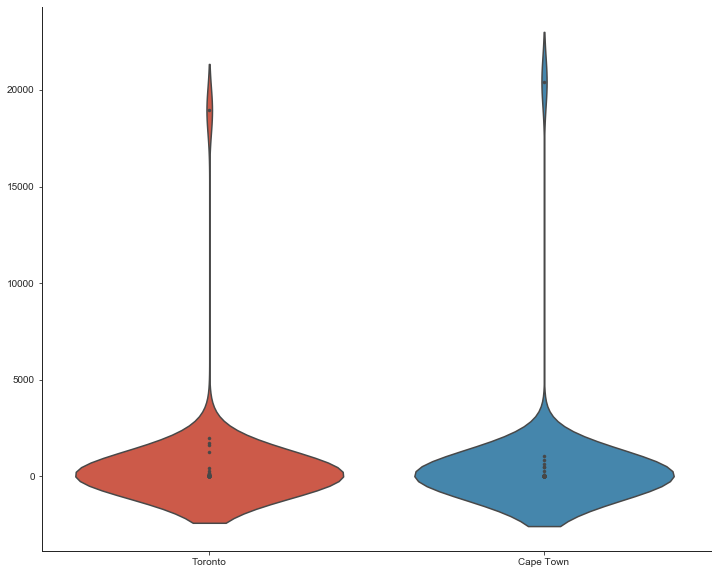

In [65]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(12, 10)
sns.violinplot(data=combined[['Toronto', 'Cape Town']], inner="points", ax=ax)    
sns.despine()

fig.savefig('violin.png')

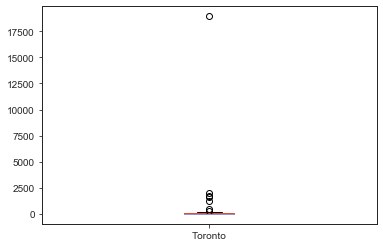